# STABLE DIFFUSION WITH FINE-TUNED CLIP

In this Jupyter notebook, we explore the integration of a custom-trained CLIP model with the Stable Diffusion model to generate images from textual descriptions. The goal is to harness the descriptive power of CLIP in understanding text and the generative capabilities of Stable Diffusion to produce contextually relevant and visually appealing images. This demonstration covers the setup of both models, data preparation, and the steps necessary to execute text-to-image translation effectively, catering to applications that require tailored content generation based on specific textual inputs.

## What is Stable Diffusion?

Stable Diffusion is a state-of-the-art text-to-image latent diffusion model. It operates within a lower-dimensional representation of images, known as latent space, rather than working directly in pixel space. This approach enhances memory efficiency significantly. In this model, an encoder compresses the image into a compact latent representation, which is then transformed back into an image by a decoder. For generating images from textual descriptions, the model employs a tokenizer and an encoder to produce text embeddings. Implementing such a model requires a UNet architecture and an appropriate scheduler to manage the diffusion process effectively.

In [1]:
pip install diffusers

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: flatbuffers 1.12.1-git20200711.33e2d80-dfsg1-0.6 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of flatbuffers or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Step 1: Loading all the required models and the scheduler

In [2]:
# Load the finetuned CLIP model 
clip_model_path = "clip_finetuned/"

In [3]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(clip_model_path)
unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True
)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [5]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

### Step 2: Create Text Embedding: Using Fine-tuned CLIP

The next step is to tokenize the text to generate embeddings. The text is used to condition the UNet model and steer the diffusion process towards something that resembles the input prompt.

In [15]:
prompt = ["generate an image of an acne type of rash on the cheek area on a fair skin"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
# Create a generator for the specified device
generator = torch.Generator(device=torch_device)
generator.manual_seed(0)  # Seed generator to create the initial latent noise
batch_size = len(prompt)

<b>Tokenize the text and generate the embeddings from the prompt:</b>

In [16]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

We also need to generate the unconditional text embeddings which are the embeddings for the padding token. These need to have the same shape (batch_size and seq_length) as the conditional text_embeddings:

In [17]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

 Concatenate the conditional and unconditional embeddings into a batch to avoid doing two forward passes:

In [18]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

### Step 3: Create random noise

Next, we will generate some initial random noise as a starting point for the diffusion process. This is the latent representation of the image, and it’ll be gradually denoised. At this point, the latent image is smaller than the final image size but that’s okay though because the model will transform it into the final 512x512 image dimensions later.

In [19]:
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator = generator,    
    device=torch_device,
)

### Step 4: Denoise the Image

We start by scaling the input with the initial noise distribution, sigma, the noise scale value, which is required for improved schedulers like UniPCMultistepScheduler:

In [20]:
latents = latents * scheduler.init_noise_sigma

The last step is to create the denoising loop that’ll progressively transform the pure noise in latents to an image described by your prompt. The denoising loop needs to do three things:

- Set the scheduler’s timesteps to use during denoising.
- Iterate over the timesteps.
- At each timestep, call the UNet model to predict the noise residual and pass it to the scheduler to compute the previous noisy sample.

In [21]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/25 [00:00<?, ?it/s]

### Step 5: Decode the image

The final step is to use the vae to decode the latent representation into an image and get the decoded output with sample:

In [22]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

Lastly, converting the image to a PIL.Image to see our generated image!

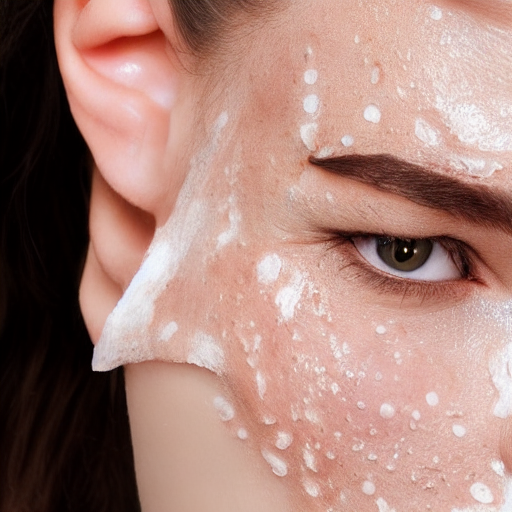

In [23]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image